In [49]:
import warnings
warnings.filterwarnings("ignore",category =RuntimeWarning)

### Master Thesis: EigenGARCH(2021)
We consider the new multivariate Dynamic Conditional Eigenvalue GARCH model (λ-MGARCH) introduced in Hetland et al. (2022 JoE). We are interested in evaluating its ability to forecast conditional covariance matrices, relative to competing multivariate GARCH models for time- varying conditional covariance matrice

### Initial Estimation

In [1]:
# Import Packages
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.special import gamma
from scipy.stats import stats
from matplotlib import pyplot as plt 
import statsmodels.api as sm
import statsmodels as sms
import yfinance as yf
from numpy.linalg import eig

import Eigen_GARCH as Eigen_GARCH

#### Import Data

In [2]:
# Use the exact same data as in R, for the DCC and GO-GARCH model
data = np.array(pd.read_csv("returns_R.csv")).T

#### Estimate

In [50]:
# Set up bounds and lambdas
covdata = np.cov(data,bias=True)
T = data.shape[1]
k = 3
eigenvalues, eigenvectors = eig(covdata)
lambdas_eig = eigenvalues
bnds = [(-np.pi/2, np.pi/2)]
bnds_eig = [(0, np.pi)]

for i in range(2*(k**2)+k+2):
    bnds_eig.append((0, 100))

# Initial values
arguments_eig = (np.asarray(data),lambdas_eig)
startingVals_eig = [np.random.uniform(0.01,0.2) for i in range(2*(k**2) + k + 3)]

# Estimation
estimation = minimize(Eigen_GARCH.eigenLikelihood , x0=startingVals_eig , 
                          args=arguments_eig , method="SLSQP", bounds=bnds_eig, 
                          options={"maxiter":100000, "ftol":10e-14})

In [51]:
# Save the estimated parameter values
phi1_eig, phi2_eig, phi3_eig, w1_eig, w2_eig, w3_eig , a11_eig , a12_eig , a13_eig, a21_eig , a22_eig, a23_eig, a31_eig , a32_eig, a33_eig , b11_eig , b12_eig, b13_eig , b21_eig , b22_eig, b23_eig, b31_eig , b32_eig, b33_eig = estimation.x

# Find the llh and information criteria for the Eigen GARCH
llh = - estimation.fun
AIC = 2 * 24 - 2 * (llh)
BIC = - 2 * llh + np.log(T) * 24

# Load into matrices
W_eig = np.array(([w1_eig], [w2_eig], [w3_eig]))
A_eig = np.array(([a11_eig, a12_eig, a13_eig],
                  [a21_eig, a22_eig, a23_eig],
                  [a31_eig, a32_eig, a33_eig]))
B_eig = np.array(([b11_eig, b12_eig, b13_eig],
                  [b21_eig, b22_eig, b23_eig],
                  [b31_eig, b32_eig, b33_eig]))
V_eig = np.array(([np.cos(phi1_eig), np.sin(phi1_eig),0], [-np.sin(phi1_eig), np.cos(phi1_eig),0 ], [0, 0,1 ])
                )@ np.array(([np.cos(phi2_eig), 0, np.sin(phi2_eig)], [0, 1,0 ], [-np.sin(phi2_eig), 0, np.cos(phi2_eig)])
                           )@ np.array(( [1, 0,0 ], [0,np.cos(phi3_eig), np.sin(phi3_eig)], [0,-np.sin(phi3_eig), np.cos(phi3_eig)]))

print(f'W: {W_eig}')
print(f'A: {A_eig}')
print(f'B: {B_eig}')
print(f'V: {V_eig}')
print(f'Log-likelihood: {llh}')
print(f'AIC: {AIC}')
print(f'BIC: {BIC}')

W: [[0.17330707]
 [0.0213585 ]
 [0.01619998]]
A: [[0.15332979 0.06420212 0.0755745 ]
 [0.         0.08608764 0.00436416]
 [0.04837691 0.01666142 0.07701433]]
B: [[0.21098589 0.         0.11442386]
 [0.         0.87533255 0.        ]
 [0.         0.         0.90426174]]
V: [[ 0.598446    0.10407646  0.79437427]
 [-0.79034937  0.23905205  0.56409395]
 [-0.1311879  -0.96541297  0.22531651]]
Log-likelihood: -12439.961294352639
AIC: 24927.922588705278
BIC: 25065.28808803995


In [5]:
# Residuals
residuals = Eigen_GARCH.eigenresiduals(estimation.x, np.asarray(data), lambdas_eig)

In [6]:
# Misspisification test
print(stats.jarque_bera(residuals[0]))
print(stats.jarque_bera(residuals[1]))
print(stats.jarque_bera(residuals[2]))

print(sm.stats.acorr_ljungbox(residuals[0], lags=[10], return_df=True))
print(sm.stats.acorr_ljungbox(residuals[1], lags=[10], return_df=True))
print(sm.stats.acorr_ljungbox(residuals[2], lags=[10], return_df=True))

Jarque_beraResult(statistic=566884.9433041513, pvalue=0.0)
Jarque_beraResult(statistic=316902.5037089753, pvalue=0.0)
Jarque_beraResult(statistic=836281.6168794846, pvalue=0.0)
      lb_stat     lb_pvalue
10  58.942066  5.743206e-09
       lb_stat     lb_pvalue
10  110.962445  3.412338e-19
       lb_stat     lb_pvalue
10  107.442408  1.747752e-18


In [7]:
# Skewness
print(stats.skew(residuals[0], axis=0, bias=True))
print(stats.skew(residuals[1], axis=0, bias=True))
print(stats.skew(residuals[2], axis=0, bias=True))

1.0415907372952826
-0.7315360806874415
-3.2297753044322923


In [8]:
# Kurtosis
print(stats.kurtosis(residuals[0], axis=0, bias=True))
print(stats.kurtosis(residuals[1], axis=0, bias=True))
print(stats.kurtosis(residuals[2], axis=0, bias=True))

77.54363227059817
57.980232098121036
93.99581418762114


In [52]:
# Calculate the covariance matrices based on the estimated values
Xtilde = V_eig.transpose() @ data
lambdas = (np.ones((T,k))).transpose()
condVar_eig = np.zeros((T,k,k))

for t in range(1,T):
    lambdas[:,t:t+1] = W_eig + A_eig @ np.multiply(Xtilde[:,t-1:t],Xtilde[:,t-1:t]) + B_eig @ lambdas[:,t-1:t]
    condVar_eig[t] = V_eig @ np.diag(np.concatenate(lambdas[:,t:t+1],axis= None)) @ V_eig.transpose()

# Make a list for each of the covariance pairs
cov_JPM_MSFT = []
for t in range(0,T):
    cov_JPM_MSFT.append(condVar_eig[t][0][1])

cov_JPM_KO = []
for t in range(0,T):
    cov_JPM_KO.append(condVar_eig[t][0][2])

cov_KO_MSFT = []
for t in range(0,T):
    cov_KO_MSFT.append(condVar_eig[t][1][2])


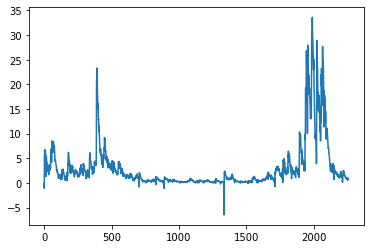

In [55]:
plt.plot(cov_JPM_MSFT)

In [56]:
# Save results 
df = pd.DataFrame(cov_JPM_KO)
df.to_csv('cov_JPM_KO_eigen.csv') 

df = pd.DataFrame(cov_JPM_MSFT)
df.to_csv('cov_JPM_MSFT_eigen.csv') 

df = pd.DataFrame(cov_KO_MSFT)
df.to_csv('cov_KO_MSFT_eigen.csv')


### Pre period

In [11]:
# Use the exact same data as in R, for the DCC and GO-GARCH model
data_pre = np.array(pd.read_csv("returns_R.csv")[0:1506]).T

In [12]:
# Set up bounds and lambdas
covdata = np.cov(data_pre,bias=True)
T = data_pre.shape[1]
k = 3
eigenvalues, eigenvectors = eig(covdata)
lambdas_eig = eigenvalues
bnds = [(-np.pi/2, np.pi/2)]
bnds_eig = [(0, np.pi)]

for i in range(2*(k**2)+k+2):
    bnds_eig.append((0, 100))

# Initial values
arguments_eig = (np.asarray(data_pre),lambdas_eig)
startingVals_eig = [np.random.uniform(0.01,0.2) for i in range(2*(k**2) + k + 3)]

# Estimation
estimation = minimize(Eigen_GARCH.eigenLikelihood , x0=startingVals_eig , 
                          args=arguments_eig , method="SLSQP", bounds=bnds_eig, 
                          options={"maxiter":100000, "ftol":10e-14})

/Users/silkesommerfugl/Desktop/Master/Eigen_GARCH.py:39: RuntimeWarning: overflow encountered in matmul
  lambdas[:,t:t+1] = W + A @ np.multiply(Xtilde[:,t-1:t],Xtilde[:,t-1:t]) + B @ lambdas[:,t-1:t]
/Users/silkesommerfugl/Desktop/Master/Eigen_GARCH.py:44: RuntimeWarning: divide by zero encountered in log
  lls3 = np.log(lambdas[2,:]) + np.multiply(Xtilde[2,:],Xtilde[2,:]) / lambdas[2,:]
/Users/silkesommerfugl/Desktop/Master/Eigen_GARCH.py:44: RuntimeWarning: divide by zero encountered in true_divide
  lls3 = np.log(lambdas[2,:]) + np.multiply(Xtilde[2,:],Xtilde[2,:]) / lambdas[2,:]
/Users/silkesommerfugl/Desktop/Master/Eigen_GARCH.py:44: RuntimeWarning: invalid value encountered in add
  lls3 = np.log(lambdas[2,:]) + np.multiply(Xtilde[2,:],Xtilde[2,:]) / lambdas[2,:]


In [13]:
# Save the estimated parameter values
phi1_eig, phi2_eig, phi3_eig, w1_eig, w2_eig, w3_eig , a11_eig , a12_eig , a13_eig, a21_eig , a22_eig, a23_eig, a31_eig , a32_eig, a33_eig , b11_eig , b12_eig, b13_eig , b21_eig , b22_eig, b23_eig, b31_eig , b32_eig, b33_eig = estimation.x

# Find the llh and information criteria for the Eigen GARCH
llh = - estimation.fun
AIC = 2 * 24 - 2 * (llh)
BIC = - 2 * llh + np.log(T) * 24

# Load into matrices
W_eig = np.array(([w1_eig, w2_eig, w3_eig]))
A_eig = np.array(([a11_eig, a12_eig, a13_eig],[a21_eig, a22_eig, a23_eig],[a31_eig, a32_eig, a33_eig]))
B_eig = np.array(([b11_eig, b12_eig, b13_eig],[b21_eig, b22_eig, b23_eig],[b31_eig, b32_eig, b33_eig]))
V_eig = np.array(([np.cos(phi1_eig), np.sin(phi1_eig),0], [-np.sin(phi1_eig), np.cos(phi1_eig),0 ], [0, 0,1 ]))@ np.array(([np.cos(phi2_eig), 0, np.sin(phi2_eig)], [0, 1,0 ], [-np.sin(phi2_eig), 0, np.cos(phi2_eig)]))@ np.array(( [1, 0,0 ], [0,np.cos(phi3_eig), np.sin(phi3_eig)], [0,-np.sin(phi3_eig), np.cos(phi3_eig)]))

print(f'Log-likelihood: {llh}')
print(f'AIC: {AIC}')
print(f'BIC: {BIC}')

Log-likelihood: -7838.240824443832
AIC: 15724.481648887664
BIC: 15852.0947466883


### Post period

In [14]:
# Use the exact same data as in R, for the DCC and GO-GARCH model
data_post = np.array(pd.read_csv("returns_R.csv")[1506:]).T

In [15]:
# Set up bounds and lambdas
covdata = np.cov(data_post,bias=True)
T = data_post.shape[1]
k = 3
eigenvalues, eigenvectors = eig(covdata)
lambdas_eig = eigenvalues
bnds = [(-np.pi/2, np.pi/2)]
bnds_eig = [(0, np.pi)]

for i in range(2*(k**2)+k+2):
    bnds_eig.append((0, 100))

# Initial values
arguments_eig = (np.asarray(data_post),lambdas_eig)
startingVals_eig = [np.random.uniform(0.01,0.2) for i in range(2*(k**2) + k + 3)]

# Estimation
estimation = minimize(Eigen_GARCH.eigenLikelihood , x0=startingVals_eig , 
                          args=arguments_eig , method="SLSQP", bounds=bnds_eig, 
                          options={"maxiter":100000, "ftol":10e-14})

/Users/silkesommerfugl/Desktop/Master/Eigen_GARCH.py:39: RuntimeWarning: invalid value encountered in matmul
  lambdas[:,t:t+1] = W + A @ np.multiply(Xtilde[:,t-1:t],Xtilde[:,t-1:t]) + B @ lambdas[:,t-1:t]
/Users/silkesommerfugl/Desktop/Master/Eigen_GARCH.py:42: RuntimeWarning: divide by zero encountered in log
  lls1 = np.log(lambdas[0,:]) + np.multiply(Xtilde[0,:],Xtilde[0,:]) / lambdas[0,:]
/Users/silkesommerfugl/Desktop/Master/Eigen_GARCH.py:42: RuntimeWarning: divide by zero encountered in true_divide
  lls1 = np.log(lambdas[0,:]) + np.multiply(Xtilde[0,:],Xtilde[0,:]) / lambdas[0,:]
/Users/silkesommerfugl/Desktop/Master/Eigen_GARCH.py:42: RuntimeWarning: invalid value encountered in add
  lls1 = np.log(lambdas[0,:]) + np.multiply(Xtilde[0,:],Xtilde[0,:]) / lambdas[0,:]


In [16]:
# Save the estimated parameter values
phi1_eig, phi2_eig, phi3_eig, w1_eig, w2_eig, w3_eig , a11_eig , a12_eig , a13_eig, a21_eig , a22_eig, a23_eig, a31_eig , a32_eig, a33_eig , b11_eig , b12_eig, b13_eig , b21_eig , b22_eig, b23_eig, b31_eig , b32_eig, b33_eig = estimation.x

# Find the llh and information criteria for the Eigen GARCH
llh = - estimation.fun
AIC = 2 * 24 - 2 * (llh)
BIC = - 2 * llh + np.log(T) * 24

# Load into matrices
W_eig = np.array(([w1_eig, w2_eig, w3_eig]))
A_eig = np.array(([a11_eig, a12_eig, a13_eig],[a21_eig, a22_eig, a23_eig],[a31_eig, a32_eig, a33_eig]))
B_eig = np.array(([b11_eig, b12_eig, b13_eig],[b21_eig, b22_eig, b23_eig],[b31_eig, b32_eig, b33_eig]))
V_eig = np.array(([np.cos(phi1_eig), np.sin(phi1_eig),0], [-np.sin(phi1_eig), np.cos(phi1_eig),0 ], [0, 0,1 ]))@ np.array(([np.cos(phi2_eig), 0, np.sin(phi2_eig)], [0, 1,0 ], [-np.sin(phi2_eig), 0, np.cos(phi2_eig)]))@ np.array(( [1, 0,0 ], [0,np.cos(phi3_eig), np.sin(phi3_eig)], [0,-np.sin(phi3_eig), np.cos(phi3_eig)]))

print(f'Log-likelihood: {llh}')
print(f'AIC: {AIC}')
print(f'BIC: {BIC}')

Log-likelihood: -4506.151534200957
AIC: 9060.303068401914
BIC: 9171.34429438389


### Forecast

In [17]:
# Use the exact same data as in R, for the DCC and GO-GARCH model
data_forecast = data

In [18]:
# Number of loops in forecast
p = 3
N = 756
# Create parameter containers and covariance matrix container
phi1_eig = np.zeros((N,1))
phi2_eig = np.zeros((N,1))
phi3_eig = np.zeros((N,1))

w1_eig = np.zeros((N,1))
w2_eig = np.zeros((N,1))
w3_eig = np.zeros((N,1))

a11_eig = np.zeros((N,1))
a12_eig = np.zeros((N,1))
a13_eig = np.zeros((N,1))
a21_eig = np.zeros((N,1))
a22_eig = np.zeros((N,1))
a23_eig = np.zeros((N,1))
a31_eig = np.zeros((N,1))
a32_eig = np.zeros((N,1))
a33_eig = np.zeros((N,1))

b11_eig = np.zeros((N,1))
b12_eig = np.zeros((N,1))
b13_eig = np.zeros((N,1))
b21_eig = np.zeros((N,1))
b22_eig = np.zeros((N,1))
b23_eig = np.zeros((N,1))
b31_eig = np.zeros((N,1))
b32_eig = np.zeros((N,1))
b33_eig = np.zeros((N,1))

forecastMatrix_eig = np.zeros((N,p,p))

In [19]:
for n in range(N):
    # Move estimation window by 5
    X = data_forecast[:,n:1505+n]
    X_f = data_forecast[:,1505+n:1505+n+1]
    print(n, "out of", N, "in Eigen-GARCH forecasting")
    # Generate new lambdas for likelihood estimation
    lambdas_eig = np.tile(np.linalg.eig(np.cov(X.T, rowvar=False))[0], (T,1))
    
    # Use prior estimation results as starting values
    startingVals_eig = list(estimation.x)
    
    # Arguments
    arguments_eig = (np.asarray(X), lambdas_eig)
    
    # Estimation
    estimation = minimize(Eigen_GARCH.eigenLikelihood, x0=startingVals_eig , args=arguments_eig , method="SLSQP", bounds=bnds_eig, options={"maxiter":100000, "ftol":10e-24})
    
    # Save parameters
    phi1_eig[n], phi2_eig[n], phi3_eig[n], w1_eig[n], w2_eig[n], w3_eig[n] , a11_eig[n] , a12_eig[n] , a13_eig[n], a21_eig [n], a22_eig[n], a23_eig[n], a31_eig[n] , a32_eig[n], a33_eig[n] , b11_eig[n] , b12_eig[n], b13_eig[n] , b21_eig[n] , b22_eig[n], b23_eig[n], b31_eig[n] , b32_eig[n], b33_eig[n] = estimation.x
    phi1, phi2, phi3, w1, w2, w3, a11, a12, a13, a21, a22, a23, a31, a32, a33, b11, b12, b13, b21, b22,b23, b31, b32,b33 = estimation.x
 
    W_eig = np.array(([w1, w2, w3]))
    A_eig = np.array(([a11, a12,a13],
                  [a21, a22,a23],
                  [a31, a32,a33]))
    B_eig = np.array(([b11, b12,b13],
                  [b21, b22,b23],
                  [b31, b32,b33]))
    V_eig = np.array(([np.cos(phi1), np.sin(phi1),0],[-np.sin(phi1), np.cos(phi1),0 ], [0, 0,1 ])
                    )@ np.array(([np.cos(phi2), 0, np.sin(phi2)], [0, 1,0 ], [-np.sin(phi2), 0, np.cos(phi2)])
                           )@ np.array(( [1, 0,0 ], [0,np.cos(phi3), np.sin(phi3)], [0,-np.sin(phi3), np.cos(phi3)]))
    
    Xtilde = V_eig.transpose() @ X
    T = 1505
    lambdas = (np.ones((k,T))).transpose()
    
    condVar_eig = np.zeros((T,k,k))
    
    for t in range(1,T):
        lambdas[t] = W_eig+np.concatenate(A_eig @ np.multiply(Xtilde[:,t-1:t],Xtilde[:,t-1:t]), axis=0 )+ B_eig @ lambdas[t-1]
        condVar_eig[t] = V_eig @ np.diag(lambdas[t]) @ V_eig.T
     
    Xtilde_f = V_eig.transpose() @ X_f
    
    lambdas_f = W_eig + np.concatenate(A_eig @ np.multiply(Xtilde_f,Xtilde_f), axis=0 )+ B_eig @ lambdas[T-1]
 
    # Conditional eigenvalue at time t+1
    #Xtilde = V_eig.transpose() @ X
    
    # Store 1-step forecast
    #forecastMatrix_eig[n,:,:] = condVar_eig[T-1]
    forecastMatrix_eig[n,:,:] = V_eig @ np.diag(lambdas_f) @ V_eig.T


0 out of 756 in Eigen-GARCH forecasting


/Users/silkesommerfugl/Desktop/Master/Eigen_GARCH.py:43: RuntimeWarning: divide by zero encountered in log
  lls2 = np.log(lambdas[1,:]) + np.multiply(Xtilde[1,:],Xtilde[1,:]) / lambdas[1,:]
/Users/silkesommerfugl/Desktop/Master/Eigen_GARCH.py:43: RuntimeWarning: divide by zero encountered in true_divide
  lls2 = np.log(lambdas[1,:]) + np.multiply(Xtilde[1,:],Xtilde[1,:]) / lambdas[1,:]
/Users/silkesommerfugl/Desktop/Master/Eigen_GARCH.py:43: RuntimeWarning: invalid value encountered in add
  lls2 = np.log(lambdas[1,:]) + np.multiply(Xtilde[1,:],Xtilde[1,:]) / lambdas[1,:]


1 out of 756 in Eigen-GARCH forecasting
2 out of 756 in Eigen-GARCH forecasting
3 out of 756 in Eigen-GARCH forecasting
4 out of 756 in Eigen-GARCH forecasting
5 out of 756 in Eigen-GARCH forecasting
6 out of 756 in Eigen-GARCH forecasting
7 out of 756 in Eigen-GARCH forecasting
8 out of 756 in Eigen-GARCH forecasting
9 out of 756 in Eigen-GARCH forecasting


/Users/silkesommerfugl/Desktop/Master/Eigen_GARCH.py:43: RuntimeWarning: overflow encountered in true_divide
  lls2 = np.log(lambdas[1,:]) + np.multiply(Xtilde[1,:],Xtilde[1,:]) / lambdas[1,:]


10 out of 756 in Eigen-GARCH forecasting
11 out of 756 in Eigen-GARCH forecasting
12 out of 756 in Eigen-GARCH forecasting
13 out of 756 in Eigen-GARCH forecasting
14 out of 756 in Eigen-GARCH forecasting
15 out of 756 in Eigen-GARCH forecasting
16 out of 756 in Eigen-GARCH forecasting
17 out of 756 in Eigen-GARCH forecasting
18 out of 756 in Eigen-GARCH forecasting
19 out of 756 in Eigen-GARCH forecasting
20 out of 756 in Eigen-GARCH forecasting
21 out of 756 in Eigen-GARCH forecasting
22 out of 756 in Eigen-GARCH forecasting
23 out of 756 in Eigen-GARCH forecasting
24 out of 756 in Eigen-GARCH forecasting
25 out of 756 in Eigen-GARCH forecasting
26 out of 756 in Eigen-GARCH forecasting
27 out of 756 in Eigen-GARCH forecasting
28 out of 756 in Eigen-GARCH forecasting
29 out of 756 in Eigen-GARCH forecasting
30 out of 756 in Eigen-GARCH forecasting


/Users/silkesommerfugl/Desktop/Master/Eigen_GARCH.py:42: RuntimeWarning: overflow encountered in true_divide
  lls1 = np.log(lambdas[0,:]) + np.multiply(Xtilde[0,:],Xtilde[0,:]) / lambdas[0,:]


31 out of 756 in Eigen-GARCH forecasting
32 out of 756 in Eigen-GARCH forecasting
33 out of 756 in Eigen-GARCH forecasting
34 out of 756 in Eigen-GARCH forecasting
35 out of 756 in Eigen-GARCH forecasting
36 out of 756 in Eigen-GARCH forecasting
37 out of 756 in Eigen-GARCH forecasting
38 out of 756 in Eigen-GARCH forecasting
39 out of 756 in Eigen-GARCH forecasting
40 out of 756 in Eigen-GARCH forecasting
41 out of 756 in Eigen-GARCH forecasting
42 out of 756 in Eigen-GARCH forecasting
43 out of 756 in Eigen-GARCH forecasting
44 out of 756 in Eigen-GARCH forecasting
45 out of 756 in Eigen-GARCH forecasting
46 out of 756 in Eigen-GARCH forecasting


/Users/silkesommerfugl/Desktop/Master/Eigen_GARCH.py:44: RuntimeWarning: overflow encountered in true_divide
  lls3 = np.log(lambdas[2,:]) + np.multiply(Xtilde[2,:],Xtilde[2,:]) / lambdas[2,:]


47 out of 756 in Eigen-GARCH forecasting
48 out of 756 in Eigen-GARCH forecasting
49 out of 756 in Eigen-GARCH forecasting
50 out of 756 in Eigen-GARCH forecasting
51 out of 756 in Eigen-GARCH forecasting
52 out of 756 in Eigen-GARCH forecasting
53 out of 756 in Eigen-GARCH forecasting
54 out of 756 in Eigen-GARCH forecasting
55 out of 756 in Eigen-GARCH forecasting
56 out of 756 in Eigen-GARCH forecasting
57 out of 756 in Eigen-GARCH forecasting
58 out of 756 in Eigen-GARCH forecasting
59 out of 756 in Eigen-GARCH forecasting
60 out of 756 in Eigen-GARCH forecasting
61 out of 756 in Eigen-GARCH forecasting
62 out of 756 in Eigen-GARCH forecasting
63 out of 756 in Eigen-GARCH forecasting
64 out of 756 in Eigen-GARCH forecasting
65 out of 756 in Eigen-GARCH forecasting
66 out of 756 in Eigen-GARCH forecasting
67 out of 756 in Eigen-GARCH forecasting
68 out of 756 in Eigen-GARCH forecasting
69 out of 756 in Eigen-GARCH forecasting
70 out of 756 in Eigen-GARCH forecasting
71 out of 756 in

/Users/silkesommerfugl/Desktop/Master/Eigen_GARCH.py:45: RuntimeWarning: overflow encountered in multiply
  lls = (lls1 + lls2 + lls3)*p*np.log(2*np.pi)


266 out of 756 in Eigen-GARCH forecasting
267 out of 756 in Eigen-GARCH forecasting
268 out of 756 in Eigen-GARCH forecasting
269 out of 756 in Eigen-GARCH forecasting
270 out of 756 in Eigen-GARCH forecasting
271 out of 756 in Eigen-GARCH forecasting
272 out of 756 in Eigen-GARCH forecasting
273 out of 756 in Eigen-GARCH forecasting
274 out of 756 in Eigen-GARCH forecasting
275 out of 756 in Eigen-GARCH forecasting
276 out of 756 in Eigen-GARCH forecasting
277 out of 756 in Eigen-GARCH forecasting
278 out of 756 in Eigen-GARCH forecasting
279 out of 756 in Eigen-GARCH forecasting
280 out of 756 in Eigen-GARCH forecasting
281 out of 756 in Eigen-GARCH forecasting
282 out of 756 in Eigen-GARCH forecasting
283 out of 756 in Eigen-GARCH forecasting
284 out of 756 in Eigen-GARCH forecasting
285 out of 756 in Eigen-GARCH forecasting
286 out of 756 in Eigen-GARCH forecasting
287 out of 756 in Eigen-GARCH forecasting
288 out of 756 in Eigen-GARCH forecasting
289 out of 756 in Eigen-GARCH fore

/Users/silkesommerfugl/Desktop/Master/Eigen_GARCH.py:42: RuntimeWarning: invalid value encountered in true_divide
  lls1 = np.log(lambdas[0,:]) + np.multiply(Xtilde[0,:],Xtilde[0,:]) / lambdas[0,:]


378 out of 756 in Eigen-GARCH forecasting
379 out of 756 in Eigen-GARCH forecasting
380 out of 756 in Eigen-GARCH forecasting
381 out of 756 in Eigen-GARCH forecasting
382 out of 756 in Eigen-GARCH forecasting
383 out of 756 in Eigen-GARCH forecasting
384 out of 756 in Eigen-GARCH forecasting
385 out of 756 in Eigen-GARCH forecasting
386 out of 756 in Eigen-GARCH forecasting
387 out of 756 in Eigen-GARCH forecasting
388 out of 756 in Eigen-GARCH forecasting
389 out of 756 in Eigen-GARCH forecasting
390 out of 756 in Eigen-GARCH forecasting
391 out of 756 in Eigen-GARCH forecasting
392 out of 756 in Eigen-GARCH forecasting
393 out of 756 in Eigen-GARCH forecasting
394 out of 756 in Eigen-GARCH forecasting
395 out of 756 in Eigen-GARCH forecasting
396 out of 756 in Eigen-GARCH forecasting
397 out of 756 in Eigen-GARCH forecasting
398 out of 756 in Eigen-GARCH forecasting
399 out of 756 in Eigen-GARCH forecasting
400 out of 756 in Eigen-GARCH forecasting
401 out of 756 in Eigen-GARCH fore

/Users/silkesommerfugl/Desktop/Master/Eigen_GARCH.py:44: RuntimeWarning: invalid value encountered in true_divide
  lls3 = np.log(lambdas[2,:]) + np.multiply(Xtilde[2,:],Xtilde[2,:]) / lambdas[2,:]


495 out of 756 in Eigen-GARCH forecasting
496 out of 756 in Eigen-GARCH forecasting
497 out of 756 in Eigen-GARCH forecasting
498 out of 756 in Eigen-GARCH forecasting
499 out of 756 in Eigen-GARCH forecasting
500 out of 756 in Eigen-GARCH forecasting
501 out of 756 in Eigen-GARCH forecasting
502 out of 756 in Eigen-GARCH forecasting
503 out of 756 in Eigen-GARCH forecasting
504 out of 756 in Eigen-GARCH forecasting
505 out of 756 in Eigen-GARCH forecasting
506 out of 756 in Eigen-GARCH forecasting
507 out of 756 in Eigen-GARCH forecasting
508 out of 756 in Eigen-GARCH forecasting
509 out of 756 in Eigen-GARCH forecasting
510 out of 756 in Eigen-GARCH forecasting
511 out of 756 in Eigen-GARCH forecasting
512 out of 756 in Eigen-GARCH forecasting
513 out of 756 in Eigen-GARCH forecasting
514 out of 756 in Eigen-GARCH forecasting
515 out of 756 in Eigen-GARCH forecasting
516 out of 756 in Eigen-GARCH forecasting
517 out of 756 in Eigen-GARCH forecasting
518 out of 756 in Eigen-GARCH fore

In [20]:
# Make a list for each of the covariance pairs
cov_JPM_MSFT_forcast = []
for t in range(1,N):
    cov_JPM_MSFT_forcast.append(forecastMatrix_eig[t][0][1])

cov_JPM_KO_forcast = []
for t in range(1,N):
    cov_JPM_KO_forcast.append(forecastMatrix_eig[t][0][2])

cov_MSFT_KO_forcast = []
for t in range(1,N):
    cov_MSFT_KO_forcast.append(forecastMatrix_eig[t][1][2])

In [21]:
# Save results
df = pd.DataFrame(cov_JPM_KO_forcast)
df.to_csv('cov_JPM_KO_forecast_eigen.csv') 

df = pd.DataFrame(cov_JPM_MSFT_forcast )
df.to_csv('cov_JPM_MSFT_forcast_eigen.csv') 

df = pd.DataFrame(cov_MSFT_KO_forcast )
df.to_csv('cov_KO_MSFT_forcast_eigen.csv') 


In [22]:
# save variances
var_BAC_forcast = []
for t in range(1,N):
    var_BAC_forcast.append(forecastMatrix_eig[t][0][0])

var_JPM_forcast = []
for t in range(1,N):
    var_JPM_forcast.append(forecastMatrix_eig[t][1][1])

var_WFC_forcast = []
for t in range(1,N):
    var_WFC_forcast.append(forecastMatrix_eig[t][2][2])

df = pd.DataFrame(var_BAC_forcast)
df.to_csv('var_BAC_forcast_eigen.csv') 

df = pd.DataFrame(var_JPM_forcast)
df.to_csv('var_JPM_forcast_eigen.csv') 

df = pd.DataFrame(var_WFC_forcast)
df.to_csv('var_WFC_forcast.csv') 

## MVP

In [23]:
data_simple = np.array(pd.read_csv("returns_R_simple.csv")).T

In [31]:
weights_eigen = np.zeros((N,1,p))
min_port_ret = np.zeros((N,1))

ell = np.array(([1, 1, 1]))
for n in range(1,N):
    w = np.matmul(np.linalg.inv(forecastMatrix_eig[n]), ell)
    weights_eigen[n,:,:] = w/sum(w)
    min_port_ret[n] = np.sum((np.multiply(weights_eigen[n,:,:], data_simple[:,1505+n])),axis=1)
    

In [32]:
df = pd.DataFrame((min_port_ret))
df.to_csv('MVP_eigen.csv') 

In [33]:
mean_min = np.mean(min_port_ret)*np.sqrt(250)
std_min = np.std(min_port_ret)*np.sqrt(250)
sharpe_ratio_min = mean_min/std_min
print(mean_min, std_min, sharpe_ratio_min)

1.0093139340505437 25.442719336603737 0.03967004944312189


## WEEKLY

In [57]:
# Use the exact same data as in R, for the DCC and GO-GARCH model
data_forecast = data

In [58]:
# Number of loops in forecast
p = 3
N = 756
# Create parameter containers and covariance matrix container
phi1_eig = np.zeros((N,1))
phi2_eig = np.zeros((N,1))
phi3_eig = np.zeros((N,1))

w1_eig = np.zeros((N,1))
w2_eig = np.zeros((N,1))
w3_eig = np.zeros((N,1))

a11_eig = np.zeros((N,1))
a12_eig = np.zeros((N,1))
a13_eig = np.zeros((N,1))
a21_eig = np.zeros((N,1))
a22_eig = np.zeros((N,1))
a23_eig = np.zeros((N,1))
a31_eig = np.zeros((N,1))
a32_eig = np.zeros((N,1))
a33_eig = np.zeros((N,1))

b11_eig = np.zeros((N,1))
b12_eig = np.zeros((N,1))
b13_eig = np.zeros((N,1))
b21_eig = np.zeros((N,1))
b22_eig = np.zeros((N,1))
b23_eig = np.zeros((N,1))
b31_eig = np.zeros((N,1))
b32_eig = np.zeros((N,1))
b33_eig = np.zeros((N,1))

min_port_ret = np.zeros((N,1))

In [59]:
for n in range(0,N-1,5):
    # Move estimation window by 5
    X = data_forecast[:,n:1506+n]
    X_f = data_forecast[:,1506+n:1506+n+1]
    print(n, "out of", N, "in Eigen-GARCH forecasting")
    # Generate new lambdas for likelihood estimation
    lambdas_eig = np.tile(np.linalg.eig(np.cov(X.T, rowvar=False))[0], (T,1))
    
    # Use prior estimation results as starting values
    startingVals_eig = list(estimation.x)
    
    # Arguments
    arguments_eig = (np.asarray(X), lambdas_eig)
    
    # Estimation
    estimation = minimize(Eigen_GARCH.eigenLikelihood, x0=startingVals_eig , args=arguments_eig , method="SLSQP", bounds=bnds_eig, options={"maxiter":100000, "ftol":10e-24})
    
    # Save parameters
    phi1_eig[n], phi2_eig[n], phi3_eig[n], w1_eig[n], w2_eig[n], w3_eig[n] , a11_eig[n] , a12_eig[n] , a13_eig[n], a21_eig [n], a22_eig[n], a23_eig[n], a31_eig[n] , a32_eig[n], a33_eig[n] , b11_eig[n] , b12_eig[n], b13_eig[n] , b21_eig[n] , b22_eig[n], b23_eig[n], b31_eig[n] , b32_eig[n], b33_eig[n] = estimation.x
    phi1, phi2, phi3, w1, w2, w3, a11, a12, a13, a21, a22, a23, a31, a32, a33, b11, b12, b13, b21, b22,b23, b31, b32,b33 = estimation.x
 
    W_eig = np.array(([w1, w2, w3]))
    A_eig = np.array(([a11, a12,a13],
                  [a21, a22,a23],
                  [a31, a32,a33]))
    B_eig = np.array(([b11, b12,b13],
                  [b21, b22,b23],
                  [b31, b32,b33]))
    V_eig = np.array(([np.cos(phi1), np.sin(phi1),0],[-np.sin(phi1), np.cos(phi1),0 ], [0, 0,1 ])
                    )@ np.array(([np.cos(phi2), 0, np.sin(phi2)], [0, 1,0 ], [-np.sin(phi2), 0, np.cos(phi2)])
                           )@ np.array(( [1, 0,0 ], [0,np.cos(phi3), np.sin(phi3)], [0,-np.sin(phi3), np.cos(phi3)]))
    
    Xtilde = V_eig.transpose() @ X
    T = 1506
    lambdas = (np.ones((k,T))).transpose()
    
    condVar_eig = np.zeros((T,k,k))
    
    for t in range(1,T):
        lambdas[t] = W_eig+np.concatenate(A_eig @ np.multiply(Xtilde[:,t-1:t],Xtilde[:,t-1:t]), axis=0 )+ B_eig @ lambdas[t-1]
        condVar_eig[t] = V_eig @ np.diag(lambdas[t]) @ V_eig.T
     
    Xtilde_f = V_eig.transpose() @ X_f
    
    lambdas_f = W_eig + np.concatenate(A_eig @ np.multiply(Xtilde_f,Xtilde_f), axis=0 )+ B_eig @ lambdas[T-1]
 
    # Conditional eigenvalue at time t+1
    #Xtilde = V_eig.transpose() @ X
    
    # Store 1-step forecast
    #forecastMatrix_eig[n,:,:] = condVar_eig[T-1]
    #1
    forecastMatrix_eig_1 = V_eig @ np.diag(lambdas_f) @ V_eig.T
    
    #2
    lambdas_f = W_eig + np.concatenate(A_eig @ np.multiply(Xtilde_f,Xtilde_f), axis=0 )+ B_eig @ lambdas_f
    forecastMatrix_eig_2 = V_eig @ np.diag(lambdas_f) @ V_eig.T
    
    #3
    lambdas_f = W_eig + np.concatenate(A_eig @ np.multiply(Xtilde_f,Xtilde_f), axis=0 )+ B_eig @ lambdas_f
    forecastMatrix_eig_3 = V_eig @ np.diag(lambdas_f) @ V_eig.T
    
    #4
    lambdas_f = W_eig + np.concatenate(A_eig @ np.multiply(Xtilde_f,Xtilde_f), axis=0 )+ B_eig @ lambdas_f
    forecastMatrix_eig_4 = V_eig @ np.diag(lambdas_f) @ V_eig.T
    
    #5
    lambdas_f = W_eig + np.concatenate(A_eig @ np.multiply(Xtilde_f,Xtilde_f), axis=0 )+ B_eig @ lambdas_f
    forecastMatrix_eig_5 = V_eig @ np.diag(lambdas_f) @ V_eig.T
    
    # Total
    forecastMatrix_eig_weekly = forecastMatrix_eig_1 +forecastMatrix_eig_2+forecastMatrix_eig_3+forecastMatrix_eig_4+forecastMatrix_eig_5
    
    #MVP
    ell = np.array(([1, 1, 1]))

    w = np.matmul(np.linalg.inv(forecastMatrix_eig_weekly), ell)
    w_weekly = w/sum(w)
    min_port_ret[n+1] = np.sum((np.multiply(w_weekly, data_simple[:,1506+n].T)))
    min_port_ret[n+2] = np.sum((np.multiply(w_weekly, data_simple[:,1506+n+1].T)))
    min_port_ret[n+3] = np.sum((np.multiply(w_weekly, data_simple[:,1506+n+2].T)))
    min_port_ret[n+4] = np.sum((np.multiply(w_weekly, data_simple[:,1506+n+3].T)))
    min_port_ret[n+5] = np.sum((np.multiply(w_weekly, data_simple[:,1506+n+4].T)))


0 out of 756 in Eigen-GARCH forecasting
5 out of 756 in Eigen-GARCH forecasting
10 out of 756 in Eigen-GARCH forecasting
15 out of 756 in Eigen-GARCH forecasting
20 out of 756 in Eigen-GARCH forecasting
25 out of 756 in Eigen-GARCH forecasting
30 out of 756 in Eigen-GARCH forecasting
35 out of 756 in Eigen-GARCH forecasting
40 out of 756 in Eigen-GARCH forecasting
45 out of 756 in Eigen-GARCH forecasting
50 out of 756 in Eigen-GARCH forecasting
55 out of 756 in Eigen-GARCH forecasting
60 out of 756 in Eigen-GARCH forecasting
65 out of 756 in Eigen-GARCH forecasting
70 out of 756 in Eigen-GARCH forecasting
75 out of 756 in Eigen-GARCH forecasting
80 out of 756 in Eigen-GARCH forecasting
85 out of 756 in Eigen-GARCH forecasting
90 out of 756 in Eigen-GARCH forecasting
95 out of 756 in Eigen-GARCH forecasting
100 out of 756 in Eigen-GARCH forecasting
105 out of 756 in Eigen-GARCH forecasting
110 out of 756 in Eigen-GARCH forecasting
115 out of 756 in Eigen-GARCH forecasting
120 out of 756

ValueError: operands could not be broadcast together with shapes (3,) (0,) 

In [62]:
df = pd.DataFrame((min_port_ret))
df.to_csv('MVP_eigen_week.csv')

In [63]:
mean_min = np.mean(min_port_ret)*np.sqrt(250)
std_min = np.std(min_port_ret)*np.sqrt(250)
sharpe_ratio_min = mean_min/std_min
print(mean_min, std_min, sharpe_ratio_min)

0.5632753946828599 26.083702147846836 0.02159491745037264
